### LASSO parameter range experiments

We want to see whether smaller models (i.e. models with fewer nonzero features) tend to generalize to new cancer types better than larger ones; this script compares/visualizes those results.

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
ll_results_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'results', 'optimizer_compare_ll', 'gene'
)

sgd_results_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'results', 'optimizer_compare_sgd', 'gene'
)

plot_gene = 'SETD2'
metric = 'aupr'

### Get coefficient information for each lasso penalty

### Get performance information for each lasso penalty

In [3]:
ll_perf_df = au.load_prediction_results_lasso_range(ll_results_dir,
                                                    'stratified',
                                                    gene=plot_gene)
ll_perf_df = (
    ll_perf_df[ll_perf_df.gene == plot_gene]
    .drop(columns=['holdout_cancer_type', 'experiment'])
    .copy()
)
ll_perf_df.head()

,auroc,aupr,gene,signal,seed,data_type,fold,lasso_param
0,0.88356,0.54013,SETD2,signal,42,train,0,0.01
1,0.77084,0.33133,SETD2,signal,42,test,0,0.01
2,0.80400,0.41205,SETD2,signal,42,cv,0,0.01
3,0.81723,0.49427,SETD2,signal,42,train,1,0.01
4,0.71473,0.31677,SETD2,signal,42,test,1,0.01


In [4]:
sgd_perf_df = au.load_prediction_results_lasso_range(sgd_results_dir,
                                                     'stratified',
                                                     gene=plot_gene)
sgd_perf_df = (
    sgd_perf_df[sgd_perf_df.gene == plot_gene]
    .drop(columns=['holdout_cancer_type', 'experiment'])
    .copy()
)
sgd_perf_df.head()

,auroc,aupr,gene,signal,seed,data_type,fold,lasso_param
0,0.97189,0.76794,SETD2,signal,42,train,0,0.01
1,0.78279,0.34253,SETD2,signal,42,test,0,0.01
2,0.68883,0.35246,SETD2,signal,42,cv,0,0.01
3,0.98195,0.81605,SETD2,signal,42,train,1,0.01
4,0.78707,0.37252,SETD2,signal,42,test,1,0.01


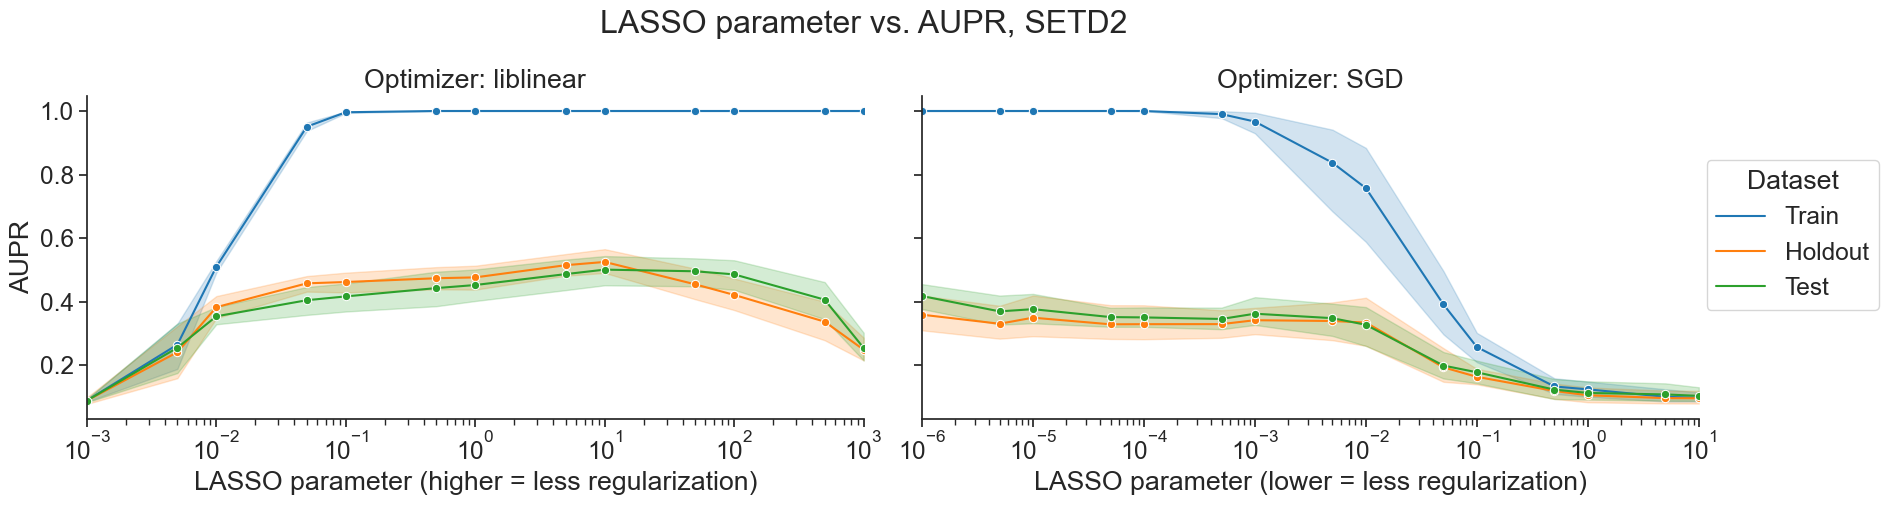

In [5]:
# same plot as before but with the "best"/"smallest" parameters marked
sns.set_style('ticks')

ll_plot_df = (
    ll_perf_df[(ll_perf_df.signal == 'signal')]
      .sort_values(by=['lasso_param'])
      .reset_index(drop=True)
)
ll_plot_df.lasso_param = ll_plot_df.lasso_param.astype(float)

sgd_plot_df = (
    sgd_perf_df[(sgd_perf_df.signal == 'signal')]
      .sort_values(by=['lasso_param'])
      .reset_index(drop=True)
)
sgd_plot_df.lasso_param = sgd_plot_df.lasso_param.astype(float)

ll_plot_df['optimizer'] = 'liblinear'
sgd_plot_df['optimizer'] = 'SGD'

plot_df = pd.concat((ll_plot_df, sgd_plot_df))

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.relplot(
        data=plot_df,
        x='lasso_param', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        marker='o', kind='line', col='optimizer',
        col_wrap=2, height=5, aspect=1.6,
        facet_kws={'sharex': False}
    )
    g.set(xscale='log', xlim=(min(plot_df.lasso_param), max(plot_df.lasso_param)))
    g.axes[0].set_xlabel('LASSO parameter (higher = less regularization)')
    g.axes[0].set_xlim((10e-4, 10e2))
    g.axes[1].set_xlabel('LASSO parameter (lower = less regularization)')
    g.axes[1].set_xlim((10e-7, 10))
    g.set_ylabels(f'{metric.upper()}')
    sns.move_legend(g, "center", bbox_to_anchor=[1.035, 0.55], frameon=True)
    g._legend.set_title('Dataset')
    new_labels = ['Train', 'Holdout', 'Test']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    g.set_titles('Optimizer: {col_name}')
     
    plt.suptitle(f'LASSO parameter vs. {metric.upper()}, {plot_gene}', y=1.0)

plt.tight_layout()